In [206]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')

In [207]:
df = pd.read_csv('D:\IMP  ML  PROJECTS\CAR PRICE PREDICTION\web scraping\MUMBAI\car_dataset_mumbai.csv')

In [208]:
cols_to_save = ['Registration Year', 'Insurance', 'Fuel Type', 'Seats', 'Kms Driven', 'Ownership', 'Engine Displacement', 'Transmission', 'Power', 'Drive Type', 'Mileage', 'Engine Type','Max_Power_clean', 'Max_Power_RPM', 'Max_Torque_Nm', 'Max_Torque_RPM', 'No. of Cylinders', 'Valves Per Cylinder', 'Fuel Supply System', 'Turbo Charger', 'Transmission Type', 'Gearbox', 'Petrol Mileage ARAI', 'Petrol Fuel Tank Capacity', 'Emission Norm Compliance', 'Front Suspension', 'Rear Suspension', 'Steering Type', 'Steering Column', 'Front Brake Type', 'Rear Brake Type', 'Length', 'Width', 'Height', 'Ground Clearance Unladen', 'Wheel Base', 'Gross Weight', 'Price', 'Diesel Mileage ARAI', 'Diesel Fuel Tank Capacity', 'Top Speed', 'Super Charge', 'Battery Capacity', 'Charging Time DC', 'Charging Time AC', 'Motor Type', 'Battery Type', 'Charging Port']

In [209]:
for col in cols_to_save:
    if "Power" == col:
        cols_to_save.remove(col)
        print("Removed Power column")

Removed Power column


In [210]:
cols_to_save = ['Registration Year', 'Insurance', 'Fuel Type', 'Seats', 'Kms Driven', 'Ownership', 'Engine Displacement', 'Transmission', 'Power', 'Drive Type', 'Mileage', 'Engine Type','Max_Power_clean', 'Max_Power_RPM', 'Max_Torque_Nm', 'Max_Torque_RPM', 'No. of Cylinders', 'Valves Per Cylinder', 'Fuel Supply System', 'Turbo Charger', 'Transmission Type', 'Gearbox', 'Petrol Mileage ARAI', 'Petrol Fuel Tank Capacity', 'Emission Norm Compliance', 'Front Suspension', 'Rear Suspension', 'Steering Type', 'Steering Column', 'Front Brake Type', 'Rear Brake Type', 'Length', 'Width', 'Height', 'Ground Clearance Unladen', 'Wheel Base', 'Gross Weight', 'Price', 'Diesel Mileage ARAI', 'Diesel Fuel Tank Capacity', 'Top Speed', 'Super Charge', 'Battery Capacity', 'Charging Time DC', 'Charging Time AC', 'Motor Type', 'Battery Type', 'Charging Port']

duplicates = [col for col in cols_to_save if cols_to_save.count(col) > 1]
print(f"Duplicate columns: {set(duplicates) if duplicates else 'None'}")
print(f"Total columns: {len(cols_to_save)}")

Duplicate columns: None
Total columns: 48


In [211]:
# .columns returns the index of column names, [15:36] slices the first 15
first_15_columns = df.columns[49 : 80].tolist()

print(first_15_columns)

['Alloy Wheel Size Front', 'Alloy Wheel Size Rear', 'Boot Space', 'Reported Ground Clearance (Unladen)', 'Top Speed', 'Reported Boot Space', 'Global NCAP Safety Rating', 'Petrol Highway Mileage', 'Front Tread', 'Rear Tread', 'Valve Configuration', 'Super Charge', 'Shock Absorbers Type', 'Turning Radius', 'No. of Airbags', 'Acceleration', '0-100kmph', 'Steering Gear Type', 'Range', 'Battery Capacity', 'Charging Time DC', 'Charging Time AC', 'Motor Type', 'Battery Type', 'Charging Time (A.C)', 'Charging Time (D.C)', 'Charging Port', 'Acceleration 0-100kmph', 'Braking (100-0kmph)', '0-100Kmph (Tested)', 'City driveability (20-80kmph)']


In [212]:
df.shape[0]

4964

## Data Cleaning

---

In [213]:
def smart_fill_categorical(dataframe, column_name):
    '''
    This function will fill the missing values in the given column with the mode or random values based on the percentage of missing values
    '''
    # Calculate missing percentage
    missing_count = dataframe[column_name].isnull().sum()
    total_rows = dataframe.shape[0]
    perct_missing = (missing_count / total_rows) * 100
    
    print(f"Processing '{column_name}': {missing_count} missing ({perct_missing:.2f}%)")
    
    if missing_count == 0:
        print("No missing values found.")
        return dataframe
    
    if perct_missing < 10:
        # Method 1: Mode
        fill_val = dataframe[column_name].mode()[0]
        dataframe[column_name] = dataframe[column_name].fillna(fill_val)
        print(f"Filled with Mode: {fill_val}")
        
    elif perct_missing < 30:
        # Method 2: Random Distribution
        existing_values = dataframe[column_name].dropna()
        dataframe[column_name] = dataframe[column_name].apply(
            lambda x: np.random.choice(existing_values) if pd.isnull(x) else x
        )
        print("Filled using Random Distribution")
        
    else:
        # Method 3: Constant
        dataframe[column_name] = dataframe[column_name].fillna('Unknown')
        print("Filled with 'Unknown' label")
        
    return dataframe

In [328]:
def apply_smart_bins(df, column_name, num_bins=4):
    # 1. Handle the 'Unknown' section first
    is_unknown = (df[column_name] == 'Unknown') | (df[column_name].isnull())
    
    # 2. Extract only the numeric part for math calculations
    numeric_data = pd.to_numeric(df.loc[~is_unknown, column_name], errors='coerce')
    
    # Check if we have enough numeric data to bin
    if numeric_data.empty:
        df[column_name] = "Unknown"
        return df

    try:
        # 3. Calculate 'num_bins' equal-sized mathematical bins on numeric data
        binned_values, bins = pd.qcut(numeric_data, q=num_bins, retbins=True, duplicates='drop')
        
        # 4. Create clean labels for your webpage (e.g., "150 - 170")
        labels = []
        for i in range(len(bins)-1):
            labels.append(f"{int(bins[i])} - {int(bins[i+1])}")
        
        # Apply the bins with labels to the numeric rows
        df.loc[~is_unknown, column_name] = pd.qcut(numeric_data, q=num_bins, labels=labels, duplicates='drop')
        
    except ValueError as e:
        print(f"Could not bin {column_name}: {e}")
    
    # 5. Finalize the column as string and restore 'Unknown'
    df[column_name] = df[column_name].astype(str)
    df.loc[is_unknown, column_name] = 'Unknown'
    
    return df

---

1. Registration Year

In [215]:
print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}\n")
print(df['Registration Year'].value_counts())

The number of missing values in the column 'Registration Year': 3

Registration Year
2011        297
2016        184
2019        182
2013        181
Aug 2017    175
           ... 
Nov 2007      1
Mar 2010      1
Nov 2024      1
Aug 2011      1
Aug 2010      1
Name: count, Length: 207, dtype: int64


In [216]:
df['Registration Year'].dtype

dtype('O')

In [217]:
def extract_month(text):
    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    # Convert input to string in case there are integers/NaNs
    text = str(text)
    
    # Check each month in our dictionary
    for month_name, month_digit in month_map.items():
        if month_name in text:
            return month_digit
            
    # Return None (nothing) if no month name is found
    return None

def extract_year(text):
    text = str(text)
    # Split the string by spaces and take the last part (works for "2013" and "Aug 2017")
    year_part = text.split()[-1]
    
    try:
        return int(year_part)
    except ValueError:
        return None 
    
# Apply the function to create the new column
df['Registration Month'] = df['Registration Year'].apply(extract_month)
df['Registration Year'] = df['Registration Year'].astype(str).apply(extract_year)

In [218]:
# Missing Values in Registration Year and Registration Month Column
print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}, ({(df['Registration Year'].isnull().sum() / df['Registration Year'].shape[0] * 100):.2f}%)")

print(f"The number of missing values in the column 'Registration Month': {df['Registration Month'].isnull().sum()}, ({(df['Registration Month'].isnull().sum() / df['Registration Month'].shape[0] * 100):.2f}%)")

The number of missing values in the column 'Registration Year': 3, (0.06%)
The number of missing values in the column 'Registration Month': 1410, (28.40%)


> Filling the missing values for Registration Month and Year Feautres

In [219]:
# 1. Get the list of existing (non-null) months
existing_months = df['Registration Month'].dropna()

# 2. Fill the missing (NaN) values by picking randomly from the existing months
df['Registration Month'] = df['Registration Month'].apply(
    lambda x: np.random.choice(existing_months) if pd.isnull(x) else x
)

# 3. Convert to int (now that there are no NaNs)
df['Registration Month'] = df['Registration Month'].astype(int)

# 4. Fill the missing values of 'Registration Year' feature with the mode of the feature
df = smart_fill_categorical(df, 'Registration Year')
df = smart_fill_categorical(df, 'Registration Month')

print(f"The number of missing values in the column 'Registration Year': {df['Registration Year'].isnull().sum()}")
print(f"The number of missing values in the column 'Registration Month': {df['Registration Month'].isnull().sum()}")

Processing 'Registration Year': 3 missing (0.06%)
Filled with Mode: 2016.0
Processing 'Registration Month': 0 missing (0.00%)
No missing values found.
The number of missing values in the column 'Registration Year': 0
The number of missing values in the column 'Registration Month': 0


2. Insurance

In [220]:
df['Insurance'].value_counts()

Insurance
Comprehensive    1940
-                1715
Third Party      1083
Zero Dep          166
Not Available      60
Name: count, dtype: int64

In [221]:
# Replace the hyphen and 'Not Available' with 'Unknown'
df['Insurance'] = df['Insurance'].replace(['-', 'Not Available'], 'Unknown')

In [222]:
df = smart_fill_categorical(df, 'Insurance')

Processing 'Insurance': 0 missing (0.00%)
No missing values found.


In [223]:
df['Insurance'].value_counts()

Insurance
Comprehensive    1940
Unknown          1775
Third Party      1083
Zero Dep          166
Name: count, dtype: int64

3. Fuel Type

In [224]:
df['Fuel Type'].value_counts()

Fuel Type
Petrol      3751
Diesel      1010
CNG          162
Electric      41
Name: count, dtype: int64

In [225]:
df = smart_fill_categorical(df, 'Fuel Type')

Processing 'Fuel Type': 0 missing (0.00%)
No missing values found.


4. Seats

In [226]:
df['Seats'].value_counts()

Seats
5 Seats    4359
7 Seats     439
8 Seats      71
6 Seats      45
4 Seats      42
2 Seats       2
Name: count, dtype: int64

In [227]:
def extract_seats(text):
    if pd.isnull(text) or text == '-':
        return None  # Handle missing or invalid values
    
    # Convert to string and take the first part
    number_part = str(text).split()[0]
    
    try:
        return int(number_part)
    except ValueError:
        return None

# Apply the function
df['Seats'] = df['Seats'].apply(extract_seats)

In [228]:
df = smart_fill_categorical(df, 'Seats')

Processing 'Seats': 6 missing (0.12%)
Filled with Mode: 5.0


5. Kms Driven

In [229]:
df['Kms Driven'].value_counts()

Kms Driven
1,60,000 Kms    210
60,000 Kms      173
1,00,000 Kms    166
30,000 Kms      148
1,50,000 Kms    121
               ... 
53,465 Kms        1
54,243 Kms        1
31,221 Kms        1
500 Kms           1
1,663 Kms         1
Name: count, Length: 1061, dtype: int64

In [230]:
def extract_kms(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # 1. Remove commas
    # 2. Split to take the first part (the number)
    clean_text = str(text).replace(',', '').split()[0]
    
    try:
        return int(clean_text)
    except ValueError:
        return None

df['Kms Driven'] = df['Kms Driven'].apply(extract_kms)

In [231]:
df = smart_fill_categorical(df, 'Kms Driven')

Processing 'Kms Driven': 0 missing (0.00%)
No missing values found.


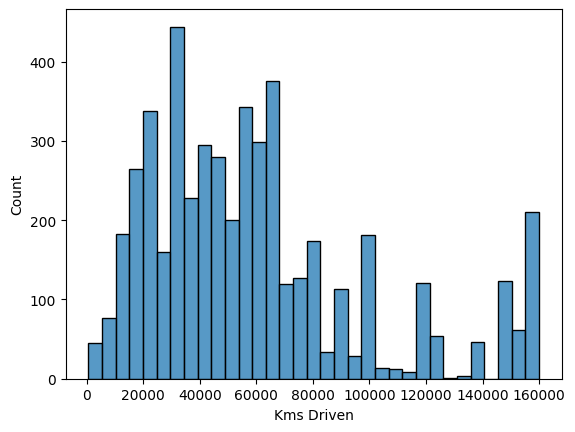

In [232]:
sns.histplot(df['Kms Driven'])
plt.show()

In [233]:
# df = apply_smart_bins(df, 'Kms Driven', 5)

In [234]:
df['Kms Driven'].value_counts()

Kms Driven
160000    210
60000     173
100000    166
30000     148
150000    121
         ... 
53465       1
54243       1
31221       1
500         1
1663        1
Name: count, Length: 1061, dtype: int64

6. Ownership

In [235]:
df = smart_fill_categorical(df, 'Ownership')

Processing 'Ownership': 3 missing (0.06%)
Filled with Mode: First Owner


In [236]:
df['Ownership'].value_counts()

Ownership
First Owner     3411
Second Owner    1277
Third Owner      215
Fifth Owner       60
Fourth Owner       1
Name: count, dtype: int64

In [237]:
# Define the mapping dictionary
ownership_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth Owner': 4,
    'Fifth Owner': 5
}

# Apply the mapping to the column
df['Ownership'] = df['Ownership'].map(ownership_map).astype(int)

7. Engine Displacement

In [238]:
df = smart_fill_categorical(df, 'Engine Displacement')

Processing 'Engine Displacement': 42 missing (0.85%)
Filled with Mode: 1197 cc


In [239]:
df['Engine Displacement'].value_counts()

Engine Displacement
1197 cc    881
1199 cc    538
1497 cc    383
1248 cc    364
998 cc     354
          ... 
1047 cc      1
4367 cc      1
1193 cc      1
1186 cc      1
2354 cc      1
Name: count, Length: 88, dtype: int64

In [240]:
def extract_engine(text):
    # Split the string and take the first part (the number)
    number_part = str(text).split()[0]
    
    try:
        return int(number_part)
    except ValueError:
        return None

df['Engine Displacement'] = df['Engine Displacement'].apply(extract_engine)

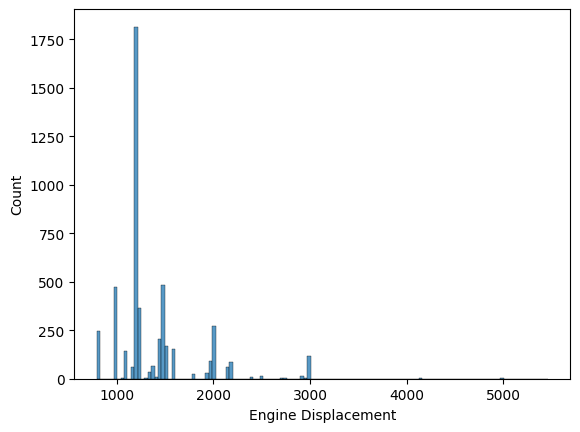

In [241]:
sns.histplot(df['Engine Displacement'])
plt.show()

In [242]:
# df = apply_smart_bins(df, 'Engine Displacement', 4)


In [243]:
df['Engine Displacement'].nunique()

88

8. Transmission

In [244]:
# Use it for Transmission
df = smart_fill_categorical(df, 'Transmission')

Processing 'Transmission': 0 missing (0.00%)
No missing values found.


In [245]:
df['Transmission'].value_counts()

Transmission
Manual       3172
Automatic    1792
Name: count, dtype: int64

10. Drive Type

In [246]:
df['Drive Type'].value_counts()

Drive Type
FWD                  3688
RWD                   597
AWD                   108
2WD                    91
4WD                    68
4X2                    30
4X4                    23
2 WD                    6
Two Wheel Drive         3
4x4                     2
RWD(with MTT)           2
Front Wheel Drive       2
All Wheel Drive         1
4x2                     1
Name: count, dtype: int64

In [247]:
# Create a mapping dictionary to group similar terms
drive_map = {
    'Front Wheel Drive': 'FWD',
    'Two Wheel Drive': '2WD',
    '2 WD': '2WD',
    'All Wheel Drive': 'AWD',
    '4X4': '4WD',
    '4x4': '4WD',
    '4X2': '2WD',
    '4x2': '2WD',
    'RWD(with MTT)': 'RWD'
}

# Apply the mapping
df['Drive Type'] = df['Drive Type'].replace(drive_map)

# Check the cleaned counts
print(df['Drive Type'].value_counts())

Drive Type
FWD    3690
RWD     599
2WD     131
AWD     109
4WD      93
Name: count, dtype: int64


In [248]:
df = smart_fill_categorical(df, 'Drive Type')

Processing 'Drive Type': 342 missing (6.89%)
Filled with Mode: FWD


11. Mileage

In [249]:
df['Mileage'].value_counts()

Mileage
27.39 kmpl    260
17 kmpl       252
18.9 kmpl     236
15.37 kmpl    180
23.84 kmpl    180
             ... 
16.42 kmpl      1
19.61 kmpl      1
14.4 kmpl       1
21.79 kmpl      1
27 km/kg        1
Name: count, Length: 316, dtype: int64

In [250]:
df = smart_fill_categorical(df, 'Mileage')

Processing 'Mileage': 547 missing (11.02%)
Filled using Random Distribution


In [251]:
# Extracting the numeric part of Mileage
def extract_mileage(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # regex to find a number (including decimals)
    match = re.search(r'(\d+\.?\d*)', str(text))
    
    if match:
        return float(match.group(1))
    return None

# Apply the function
df['Mileage'] = df['Mileage'].apply(extract_mileage)

In [252]:
# df = apply_smart_bins(df, 'Mileage', 4)
# print(df['Mileage'].value_counts())

In [253]:
print(df["Mileage"].head())

0    17.20
1    19.10
2    12.34
3    14.70
4    19.17
Name: Mileage, dtype: float64


12. Engine Type

In [254]:
df['Engine Type'].value_counts()

Engine Type
In-Line Engine               491
i-VTEC Petrol Engine         375
DDiS Diesel Engine           340
Kappa VTVT Petrol Engine     322
Petrol Engine                198
                            ... 
1.2 l Bi-Fuel                  1
Turbocharged Diesel Engin      1
4 Cylinder, VCDi               1
1.2 l i-CNG                    1
2.2L Diesel Engine             1
Name: count, Length: 314, dtype: int64

In [255]:
df = smart_fill_categorical(df, 'Engine Type')

Processing 'Engine Type': 89 missing (1.79%)
Filled with Mode: In-Line Engine


In [256]:
def simplify_engine_type(text):
    text = str(text).lower()
    if pd.isnull(text) or text == '-':
        return 'Other'
    
    if 'in-line' in text or 'inline' in text:
        return 'In-Line'
    elif 'v' in text and ('engine' in text or 'cylinder' in text): # Matches V6, V8, V-type
        return 'V-Type'
    elif 'turbo' in text:
        return 'Turbocharged'
    elif 'vtec' in text or 'vtvt' in text or 'ddis' in text:
        return 'Standard Brand Engine'
    else:
        return 'Standard'

# Apply the simplification
df['Engine Type'] = df['Engine Type'].apply(simplify_engine_type)

In [257]:
df["Engine Type"].value_counts()

Engine Type
Standard                 2240
V-Type                   1404
In-Line                   638
Standard Brand Engine     487
Turbocharged              195
Name: count, dtype: int64

13. Max Power

In [258]:
df['Max Power'].value_counts()

Max Power
74bhp@4000rpm          337
73bhp@6000rpm          180
88.76bhp@6000rpm       168
118PS at 6,600 rpm     152
68.05bhp@5500rpm       134
                      ... 
113.98bhp@4000rpm        1
120.69bhp@6500rpm        1
245bhp@2910-4500rpm      1
68.05bhp@6000rpm         1
187.4bhp@7000rpm         1
Name: count, Length: 392, dtype: int64

In [259]:
df = smart_fill_categorical(df, 'Max Power')

Processing 'Max Power': 1 missing (0.02%)
Filled with Mode: 74bhp@4000rpm


In [260]:
def extract_power_and_rpm(text):
    if pd.isnull(text) or text == '-':
        return None, None
    
    text = str(text).lower().replace(',', '')
    
    # 1. Extract the Power (handles decimals and integers)
    # Looks for numbers before 'bhp' or 'ps'
    power_match = re.search(r'(\d+\.?\d*)\s*(bhp|ps)', text)
    power = float(power_match.group(1)) if power_match else None
    
    # 2. Extract the RPM
    # Looks for numbers after '@' or 'at'
    # In cases like "2910-4500rpm", we take the higher value (4500)
    rpm_match = re.findall(r'(\d{4,})', text) # Finds 4+ digit numbers
    rpm = float(rpm_match[-1]) if rpm_match else None
    
    return power, rpm

# Apply to create two new columns
df[['Max_Power_clean', 'Max_Power_RPM']] = df['Max Power'].apply(
    lambda x: pd.Series(extract_power_and_rpm(x))
)

In [261]:
df['Max_Power_clean'].value_counts()

Max_Power_clean
74.00     339
73.00     180
88.76     171
118.00    165
68.05     137
         ... 
201.10      1
473.38      1
200.00      1
74.41       1
147.90      1
Name: count, Length: 277, dtype: int64

In [262]:
df = smart_fill_categorical(df, 'Max_Power_clean')
print(df['Max_Power_clean'].value_counts())

Processing 'Max_Power_clean': 67 missing (1.35%)
Filled with Mode: 74.0
Max_Power_clean
74.00     406
73.00     180
88.76     171
118.00    165
68.05     137
         ... 
201.10      1
473.38      1
200.00      1
74.41       1
147.90      1
Name: count, Length: 277, dtype: int64


In [263]:
df = smart_fill_categorical(df, 'Max_Power_RPM')
print(df['Max_Power_RPM'].head())

Processing 'Max_Power_RPM': 44 missing (0.89%)
Filled with Mode: 6000.0
0    5500.0
1    4000.0
2    5000.0
3    5500.0
4    6250.0
Name: Max_Power_RPM, dtype: float64


14. Max Torque

In [264]:
df['Max Torque'].value_counts()

Max Torque
190Nm@2000rpm         337
110Nm@4800rpm         287
90Nm@3500rpm          235
114Nm@3500rpm         185
101Nm@3000rpm         180
                     ... 
96.5Nm@3500rpm          1
95.2Nm@4000rpm          1
250Nm@1500-2500rpm      1
327Nm@2600rpm           1
226Nm@4400rpm           1
Name: count, Length: 319, dtype: int64

In [265]:
def extract_torque_features(text):
    if pd.isnull(text) or text == '-':
        return None, None
    
    # Standardize text: lowercase and remove commas
    text = str(text).lower().replace(',', '')
    
    # 1. Extract Torque (Nm)
    torque_match = re.search(r'(\d+\.?\d*)\s*(nm|kgm|nm@)', text)
    torque = float(torque_match.group(1)) if torque_match else None
    
    # 2. Extract RPM: 
    rpm_match = re.findall(r'(\d{4,})', text)
    rpm = float(rpm_match[-1]) if rpm_match else None
    
    return torque, rpm

# Create two new columns
df[['Max_Torque_Nm', 'Max_Torque_RPM']] = df['Max Torque'].apply(
    lambda x: pd.Series(extract_torque_features(x))
)

In [266]:
for col in ['Max_Torque_Nm', 'Max_Torque_RPM']:
    df = smart_fill_categorical(df, col)
    print(df[col].head())

Processing 'Max_Torque_Nm': 68 missing (1.37%)
Filled with Mode: 190.0
0    178.0
1    250.0
2    250.0
3    253.0
4     96.0
Name: Max_Torque_Nm, dtype: float64
Processing 'Max_Torque_RPM': 43 missing (0.87%)
Filled with Mode: 4000.0
0    4500.0
1    2750.0
2    3600.0
3    3500.0
4    3500.0
Name: Max_Torque_RPM, dtype: float64


15. No. of Cylinders

In [267]:
df['No. of Cylinders'].value_counts()

No. of Cylinders
4.0    3688
3.0    1095
6.0     133
8.0       7
Name: count, dtype: int64

In [268]:
df = smart_fill_categorical(df, 'No. of Cylinders')

Processing 'No. of Cylinders': 41 missing (0.83%)
Filled with Mode: 4.0


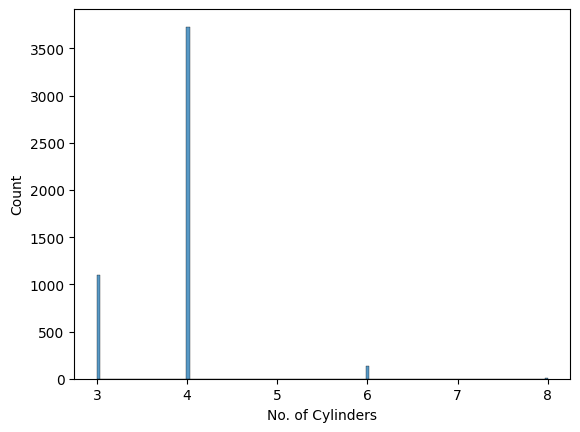

In [269]:
sns.histplot(df['No. of Cylinders'])
plt.show()

16. Valves Per Cylinder

In [270]:
df['Valves Per Cylinder'].value_counts()

Valves Per Cylinder
4.0    4577
3.0     222
2.0     124
Name: count, dtype: int64

In [271]:
df = smart_fill_categorical(df, 'Valves Per Cylinder')

Processing 'Valves Per Cylinder': 41 missing (0.83%)
Filled with Mode: 4.0


17. Fuel Supply System

In [272]:
df['Fuel Supply System'].value_counts()

Fuel Supply System
MPFI                                  1244
MPFi                                   849
CRDi                                   625
CRDI                                   185
Direct Injection                       154
PGM-Fi                                 120
EFI(Electronic Fuel Injection)          81
EFI (Electronic Fuel Injection)         80
GDi                                     77
SEFI                                    66
TSI                                     28
MPi                                     28
PGM - Fi                                28
EFI                                     16
multi-point fuel injection              15
MPI                                     15
Intelligent-Gas Port Injection           8
ISG                                      6
DHOC                                     5
Common rail direct injection             5
EFIC                                     5
Multi Point Fuel Injection               5
TDCi                               

In [273]:
df = smart_fill_categorical(df, 'Fuel Supply System')

Processing 'Fuel Supply System': 1281 missing (25.81%)
Filled using Random Distribution


In [274]:
def clean_fuel_system(text):
    if pd.isnull(text):
        return 'Other'
    
    text = str(text).lower().strip()
    
    # Grouping logic
    if 'mpfi' in text or 'mpi' in text or 'pgm' in text or 'multi' in text:
        return 'MPFi'
    elif 'crdi' in text or 'common rail' in text or 'tdci' in text or 'ddis' in text or 'cdi' in text:
        return 'CRDi'
    elif 'direct injection' in text or 'gdi' in text or 'di' in text or 'tsi' in text:
        return 'Direct Injection'
    elif 'efi' in text or 'sefi' in text:
        return 'EFI'
    else:
        return 'Other'

# Apply the cleaning function
df['Fuel Supply System'] = df['Fuel Supply System'].apply(clean_fuel_system)

# Check the new distribution
print(df['Fuel Supply System'].value_counts())

Fuel Supply System
MPFi                3122
CRDi                1087
Direct Injection     373
EFI                  346
Other                 36
Name: count, dtype: int64


18. Turbo Charger

In [275]:
df['Turbo Charger'].value_counts()

Turbo Charger
No       2843
Yes      1459
Twin       41
YES        16
yes         9
twin        3
Turbo       1
NO          1
Name: count, dtype: int64

In [276]:
# Create a mapping dictionary to group similar terms
turbo_map = {
    'NO' : 'No',
    'YES' : 'Yes',
    'yes' : 'Yes',
    'Turbo' : 'Yes',
    'twin' : 'Yes',
    'no' : 'No',
    'turbo' : 'Yes',
    'TURBO' : 'Yes'
}
# Apply the mapping
df['Turbo Charger'] = df['Turbo Charger'].replace(turbo_map)


In [277]:
df['Turbo Charger'].value_counts()

Turbo Charger
No      2844
Yes     1488
Twin      41
Name: count, dtype: int64

In [278]:
df = smart_fill_categorical(df, 'Turbo Charger')

Processing 'Turbo Charger': 591 missing (11.91%)
Filled using Random Distribution


19. Transmission Type

In [279]:
df['Transmission Type'].isnull().sum()

np.int64(0)

In [280]:
df['Transmission Type'].value_counts()

Transmission Type
Manual       3172
Automatic    1792
Name: count, dtype: int64

20. Gearbox

In [281]:
df['Gearbox'].value_counts()

Gearbox
5 Speed                            2622
6 Speed                             374
CVT                                 326
5-Speed                             295
8 Speed                             238
                                   ... 
6 Speed IMT                           1
8-Speed AMG DCT                       1
5 Manual                              1
5-Speed`                              1
Mercedes Benz 7 Speed Automatic       1
Name: count, Length: 88, dtype: int64

In [282]:
df = smart_fill_categorical(df, 'Gearbox')

Processing 'Gearbox': 28 missing (0.56%)
Filled with Mode: 5 Speed


In [283]:
def extract_gear_count(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # Standardize text
    text = str(text).lower()
    
    # Use regex to find the first digit (the speed/gear count)
    match = re.search(r'(\d+)', text)
    
    if match:
        return int(match.group(1))

    if 'cvt' in text or 'ivt' in text:
        return 6 # A common average for CVTs in datasets
        
    return None

# Apply the function
df['Gearbox'] = df['Gearbox'].apply(extract_gear_count)

In [284]:
df['Gearbox'].value_counts()

Gearbox
5.0     3012
6.0      980
8.0      301
4.0      270
7.0      264
9.0       90
1.0       14
10.0       1
Name: count, dtype: int64

21. Petrol Mileage ARAI

In [285]:
df['Petrol Mileage ARAI'].isnull().sum()

np.int64(1297)

###### Here we filling with 0 because this feature is only for the cars with fuel type 'Petrol'

In [286]:
# 1. Properly fill non-petrol rows with 0 using .loc
df.loc[df['Fuel Type'] != 'Petrol', 'Petrol Mileage ARAI'] = df.loc[df['Fuel Type'] != 'Petrol', 'Petrol Mileage ARAI'].fillna(0)

# 2. Extract the Petrol rows
petrol_mask = df['Fuel Type'] == 'Petrol'
petrol_rows = df[petrol_mask].copy()

petrol_rows = smart_fill_categorical(petrol_rows, 'Petrol Mileage ARAI')

# Map the filled values back to the original dataframe
df.loc[petrol_mask, 'Petrol Mileage ARAI'] = petrol_rows['Petrol Mileage ARAI']

Processing 'Petrol Mileage ARAI': 84 missing (2.24%)
Filled with Mode: 17 kmpl


In [287]:
df['Petrol Mileage ARAI'].head()

0     17.2 kmpl
1             0
2    12.34 kmpl
3     17.9 kmpl
4    19.17 kmpl
Name: Petrol Mileage ARAI, dtype: object

In [288]:
def extract_petrol_mileage(text):
    if pd.isnull(text) or text == '-':
        return None
    
    # Use regex to find numbers (including decimals)
    # This handles "17 kmpl", "15.37 kmpl", etc.
    match = re.search(r'(\d+\.?\d*)', str(text))
    
    if match:
        return float(match.group(1))
    return None

# Apply the function to the column
df['Petrol Mileage ARAI'] = df['Petrol Mileage ARAI'].apply(extract_petrol_mileage)

# Check the first few results
print(df['Petrol Mileage ARAI'].value_counts())

Petrol Mileage ARAI
0.00     1213
17.00     333
18.90     236
15.37     180
23.84     180
         ... 
14.85       1
16.42       1
17.69       1
14.40       1
21.79       1
Name: count, Length: 243, dtype: int64


In [289]:
is_petrol = df['Fuel Type'] == 'Petrol'
petrol_df = df[is_petrol].copy()
df.loc[is_petrol, 'Petrol Mileage ARAI'] = petrol_df['Petrol Mileage ARAI']
df.loc[~is_petrol, 'Petrol Mileage ARAI'] = 'Not Applicable'
print(df['Petrol Mileage ARAI'].value_counts())

Petrol Mileage ARAI
Not Applicable    1213
17.0               333
18.9               236
15.37              180
23.84              180
                  ... 
14.85                1
16.42                1
17.69                1
14.4                 1
21.79                1
Name: count, Length: 243, dtype: int64


22. Petrol Fuel Tank Capacity

In [290]:
df['Petrol Fuel Tank Capacity'].value_counts()

Petrol Fuel Tank Capacity
35 Litres    1022
40 Litres     545
43 Litres     398
45 Litres     336
42 Litres     271
32 Litres     244
37 Litres     196
50 Litres     137
60 Litres      92
68 Litres      80
55 Litres      56
48 Litres      45
28 Litres      32
44 Litres      25
57 Litres      19
66 Litres      17
52 Litres      15
27 Litres      14
51 Litres      12
80 Litres      10
62 Litres       9
41 Litres       8
82 Litres       7
90 Litres       6
73 Litres       6
65 Litres       5
56 Litres       4
59 Litres       3
58 Litres       3
83 Litres       2
69 Litres       2
88 Litres       1
64 Litres       1
89 Litres       1
93 Litres       1
54 Litres       1
Name: count, dtype: int64

In [291]:
def extract_numeric(text):
    if pd.isnull(text) or text == '-':
        return None
    match = re.search(r'(\d+\.?\d*)', str(text))
    return float(match.group(1)) if match else None

df['Petrol Fuel Tank Capacity'] = df['Petrol Fuel Tank Capacity'].apply(extract_numeric)

# 2. Fill non-petrol rows with 0
df.loc[df['Fuel Type'] != 'Petrol', 'Petrol Fuel Tank Capacity'] = df.loc[df['Fuel Type'] != 'Petrol', 'Petrol Fuel Tank Capacity'].fillna(0)

# 3. Use your smart_fill logic for the Petrol rows only
petrol_mask = df['Fuel Type'] == 'Petrol'
petrol_rows = df[petrol_mask].copy()

# Apply your custom smart_fill function
petrol_rows = smart_fill_categorical(petrol_rows, 'Petrol Fuel Tank Capacity')

# Map the filled values back to the original column
df.loc[petrol_mask, 'Petrol Fuel Tank Capacity'] = petrol_rows['Petrol Fuel Tank Capacity']

Processing 'Petrol Fuel Tank Capacity': 125 missing (3.33%)
Filled with Mode: 35.0


In [292]:
is_petrol = df['Fuel Type'] == 'Petrol'
petrol_df = df[is_petrol].copy()

# petrol_df = apply_smart_bins(petrol_df, 'Petrol Fuel Tank Capacity', num_bins=4)

df.loc[is_petrol, 'Petrol Fuel Tank Capacity'] = petrol_df['Petrol Fuel Tank Capacity']
df.loc[~is_petrol, 'Petrol Fuel Tank Capacity'] = 'Not Applicable'

22. Emission Norm Compliance

In [293]:
df['Emission Norm Compliance'].value_counts()

Emission Norm Compliance
BS IV                               2593
BS VI                                862
BS VI 2.0                            626
BSIV                                 117
Euro IV                               85
Bharat Stage III                      64
Euro VI                               57
ZEV                                   41
Bharat Stage IV                       23
Euro V                                19
BS III                                 3
BS III, BS IV (For Metro Cities)       1
BSIII                                  1
Name: count, dtype: int64

In [294]:
df = smart_fill_categorical(df, 'Emission Norm Compliance')

Processing 'Emission Norm Compliance': 472 missing (9.51%)
Filled with Mode: BS IV


In [295]:
def clean_emission_norm(text):
    if pd.isnull(text):
        return 'Other'
    
    text = str(text).upper().replace(' ', '')
    
    if 'BSVI2.0' in text:
        return 'BS VI 2.0'
    elif 'BSVI' in text or 'EUROVI' in text:
        return 'BS VI'
    elif 'BSIV' in text or 'EUROIV' in text or 'BHARATSTAGEIV' in text:
        return 'BS IV'
    elif 'BSIII' in text or 'BHARATSTAGEIII' in text:
        return 'BS III'
    elif 'EUROV' in text:
        return 'BS V' # Less common, but seen in some imports
    elif 'ZEV' in text:
        return 'ZEV'
    else:
        return 'Other'

# Apply the cleaning function
df['Emission Norm Compliance'] = df['Emission Norm Compliance'].apply(clean_emission_norm)

In [296]:
df['Emission Norm Compliance'].value_counts()

Emission Norm Compliance
BS IV        3291
BS VI         919
BS VI 2.0     626
BS III         68
ZEV            41
BS V           19
Name: count, dtype: int64

23. Front Suspension

In [297]:
df = smart_fill_categorical(df, 'Front Suspension')

Processing 'Front Suspension': 65 missing (1.31%)
Filled with Mode: MacPherson Strut


In [298]:
df['Front Suspension'].value_counts()

Front Suspension
MacPherson Strut                                                                         2172
MacPherson Strut suspension                                                               500
McPherson Strut                                                                           389
McPherson Strut With Coil Spring                                                          153
McPherson strunt with stabilizer, coil spring                                             152
                                                                                         ... 
Dual Helix Independent Suspension                                                           1
Mac Pherson type                                                                            1
McPherson Suspension With Lower Triangular Links & Torsion Stabilizer                       1
McPherson Strut with Linear Cylindrical Coil Spring and Tubular Stabilizer Bar system       1
Double Wishbone with Coil Spring           

In [299]:
def clean_suspension(text):
    if pd.isnull(text):
        return 'Other'
    
    text = str(text).lower()
    
    if 'macpherson' in text or 'mcpherson' in text or 'mac pherson' in text:
        return 'MacPherson Strut'
    elif 'double wishbone' in text:
        return 'Double Wishbone'
    elif 'multi-link' in text or 'multilink' in text:
        return 'Multi-Link'
    elif 'independent' in text:
        return 'Independent'
    else:
        return 'Standard/Other'

# Apply the cleaning
df['Front Suspension'] = df['Front Suspension'].apply(clean_suspension)

In [300]:
df['Front Suspension'].value_counts()   

Front Suspension
MacPherson Strut    4451
Standard/Other       322
Double Wishbone      169
Multi-Link            13
Independent            9
Name: count, dtype: int64

24. Rear Suspension

In [301]:
df = smart_fill_categorical(df, 'Rear Suspension')

Processing 'Rear Suspension': 179 missing (3.61%)
Filled with Mode: Torsion Beam


In [302]:
df['Rear Suspension'].value_counts()

Rear Suspension
Torsion Beam                                                                                     1247
Coupled Torsion Beam                                                                              443
Rear twist beam                                                                                   423
Twist Beam                                                                                        204
3 link Rigid                                                                                      180
                                                                                                 ... 
Five Link Integral Suspension                                                                       1
Trailing Arm With Coil Spring                                                                       1
Twist Beam with Coil Spring                                                                         1
Multi-Element Axle , With One Longitudinal & Three Transverse Link

In [303]:
def clean_rear_suspension(text):
    if pd.isnull(text):
        return 'Other'
    
    text = str(text).lower()
    
    # Logic for grouping
    if 'torsion' in text or 'twist beam' in text or 'coupled' in text:
        return 'Torsion/Twist Beam'
    elif 'multi-link' in text or 'multilink' in text or '5-link' in text or 'five link' in text:
        return 'Multi-Link'
    elif 'leaf spring' in text or 'rigid' in text:
        return 'Leaf Spring/Rigid Axle'
    elif 'trailing arm' in text:
        return 'Trailing Arm'
    elif 'double wishbone' in text:
        return 'Double Wishbone'
    else:
        return 'Standard/Other'

# Apply the cleaning
df['Rear Suspension'] = df['Rear Suspension'].apply(clean_rear_suspension)

25. Steering Type

In [304]:
df = smart_fill_categorical(df, 'Steering Type')

Processing 'Steering Type': 176 missing (3.55%)
Filled with Mode: Power


In [305]:
df['Steering Type'].value_counts()

Steering Type
Power         3604
Electric       987
Manual         303
Electronic      36
Electrical      11
Hydraulic       11
power            7
electric         3
EPAS             2
Name: count, dtype: int64

In [306]:
def clean_steering(text):
    if pd.isnull(text):
        return 'Other'
    
    text = str(text).lower().strip()
    
    # Grouping logic
    if text in ['electric', 'electronic', 'electrical', 'epas']:
        return 'Electric'
    elif text in ['power']:
        return 'Power' # You can also group this with Hydraulic if preferred
    elif text in ['hydraulic']:
        return 'Hydraulic'
    elif text in ['manual']:
        return 'Manual'
    else:
        return 'Other'

# Apply the cleaning
df['Steering Type'] = df['Steering Type'].apply(clean_steering)

# Check the results
print(df['Steering Type'].value_counts())

Steering Type
Power        3611
Electric     1039
Manual        303
Hydraulic      11
Name: count, dtype: int64


26. Streeing Column

In [307]:
df['Steering Column'].value_counts()

Steering Column
Tilt                              1545
Tilt & Telescopic                  999
Tilt & Collapsible                 424
Collapsible                        263
Tilt Steering                      199
Adjustable                         151
Tilt & Collapsible Steering         96
Electrically Adjustable             92
Height & Reach                      69
Collapsible Steering Column         54
Collapsible Steering                45
Tilt & telescopic                   23
Telescopic & Tilt                   22
Height & Reach Adjustable           14
Tilt and Telescopic                 11
Tiltable Steering Wheel Column      10
Telescopic                           9
Rack & Pinion                        8
Tilt and Collapsible                 6
Tilt Adjustment                      6
Tilt Adjustable                      6
Tilt&Telescopic                      6
Tilt Steering Wheel                  6
Tiltable & Telescopic                6
Tilt & Adjustable Steering           5
Tilt & Te

In [308]:
def clean_steering_column_details(text):
    if pd.isnull(text):
        return 'Fixed'
    
    text = str(text).lower().replace('&', 'and')
    
    # 1. Premium / Luxury (Electric or reach adjustment)
    if 'electr' in text:
        return 'Power Adjustable'
    elif 'telescopic' in text or 'reach' in text:
        return 'Tilt and Telescopic'
    
    # 2. Standard (Tilt/Height only)
    elif 'tilt' in text or 'height' in text or 'adjustable' in text:
        return 'Tilt Only'
    
    # 3. Safety focused / Basic (Collapsible/Fixed)
    elif 'collapsible' in text or 'absorbing' in text:
        return 'Collapsible/Fixed'
    
    else:
        return 'Fixed'

# Apply the cleaning
df['Steering Column'] = df['Steering Column'].apply(clean_steering_column_details)

# Check the new distribution
print(df['Steering Column'].value_counts())

Steering Column
Tilt Only              2468
Tilt and Telescopic    1172
Fixed                   864
Collapsible/Fixed       363
Power Adjustable         97
Name: count, dtype: int64


In [309]:
df = smart_fill_categorical(df, 'Steering Column')

Processing 'Steering Column': 0 missing (0.00%)
No missing values found.


27. Front Brake Type

In [310]:
df = smart_fill_categorical(df, 'Front Brake Type')

Processing 'Front Brake Type': 32 missing (0.64%)
Filled with Mode: Disc


In [311]:
df['Front Brake Type'].value_counts()

Front Brake Type
Disc                                        3399
Ventilated Disc                             1442
Solid Disc                                    86
ventilated disc                                8
Disk                                           7
Ventilated Discs                               5
Disc & Caliper Type                            3
Ventilated Disk                                3
Electric Parking Brake                         2
ventilated Disc                                2
disc                                           2
Vacuum assisted hydraulic dual circuit w       1
Ventilated discs                               1
Twin piston sliding fist caliper               1
Disc,internally ventilated                     1
Ventilated DIsc                                1
Name: count, dtype: int64

In [312]:
def clean_front_brakes(text):
    if pd.isnull(text):
        return 'Disc' # Disc is the safest majority assumption
    
    text = str(text).lower()
    
    # Ventilated discs are premium/high-performance
    if 'ventilated' in text or 'internally' in text:
        return 'Ventilated Disc'
    
    # Electric parking brake usually implies high-end disc systems
    elif 'electric' in text:
        return 'Ventilated Disc'
    
    # Standard discs (including 'disk', 'solid', or generic 'disc')
    elif 'disc' in text or 'disk' in text:
        return 'Solid Disc'
    
    else:
        return 'Other'

# Apply the cleaning
df['Front Brake Type'] = df['Front Brake Type'].apply(clean_front_brakes)
print(df['Front Brake Type'].value_counts())

Front Brake Type
Solid Disc         3497
Ventilated Disc    1465
Other                 2
Name: count, dtype: int64


28. Rear Brake Type

In [313]:
df = smart_fill_categorical(df, 'Rear Brake Type')

Processing 'Rear Brake Type': 32 missing (0.64%)
Filled with Mode: Drum


In [314]:
df['Rear Brake Type'].value_counts()

Rear Brake Type
Drum                                        3811
Disc                                         904
Ventilated Disc                               97
Self-Adjusting Drum                           60
Solid Disc                                    32
Discs                                         31
ventilated disc                                8
Leading & Trailing Drum                        6
Disc & Caliper Type                            3
disc                                           2
Ventilated Discs                               2
Electric Parking Brake                         2
Vacuum assisted hydraulic dual circuit w       1
DiscEmmission Norm Compliance                  1
Ventilated discs                               1
Leading-Trailing Drum                          1
Drums                                          1
Single piston sliding fist                     1
Name: count, dtype: int64

In [315]:
def clean_rear_brakes(text):
    if pd.isnull(text):
        return 'Drum' # Drum is the most common rear brake for standard cars
    
    text = str(text).lower()
    
    # Ventilated is the highest performance tier
    if 'ventilated' in text:
        return 'Ventilated Disc'
    
    # Disc/Solid Disc is the middle/premium tier
    elif 'disc' in text or 'disk' in text or 'electric' in text or 'piston' in text:
        return 'Solid Disc'
    
    # Drum is the budget/standard tier
    elif 'drum' in text:
        return 'Drum'
    
    else:
        return 'Drum'

# Clean the data and replace the old feature
df['Rear Brake Type'] = df['Rear Brake Type'].apply(clean_rear_brakes)

# Verify the result
print(df['Rear Brake Type'].value_counts())

Rear Brake Type
Drum               3880
Solid Disc          976
Ventilated Disc     108
Name: count, dtype: int64


31. Length, Width, Height

In [316]:
df = smart_fill_categorical(df, 'Length')
df = smart_fill_categorical(df, 'Width')
df = smart_fill_categorical(df, 'Height')

Processing 'Length': 8 missing (0.16%)
Filled with Mode: 3995 mm
Processing 'Width': 8 missing (0.16%)
Filled with Mode: 1695 mm
Processing 'Height': 8 missing (0.16%)
Filled with Mode: 1510 mm


In [317]:
def extract_dimension(text):
    if pd.isnull(text) or text == '-':
        return None
    # Extract digits and decimals (e.g., "1735 mm" -> 1735.0)
    match = re.search(r'(\d+\.?\d*)', str(text))
    return float(match.group(1)) if match else None

# Applying to all three columns and replacing the originals as requested
for col in ['Width', 'Length', 'Height']:
    if col in df.columns:
        df[col] = df[col].apply(extract_dimension)

# Verify that the columns are now numeric
print(df[['Width', 'Length', 'Height']].info())
print(df[['Width', 'Length', 'Height']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4964 entries, 0 to 4963
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Width   4964 non-null   float64
 1   Length  4964 non-null   float64
 2   Height  4964 non-null   float64
dtypes: float64(3)
memory usage: 116.5 KB
None
    Width  Length  Height
0  1760.0  4225.0  1612.0
1  1800.0  4365.0  1645.0
2  1835.0  4699.0  1760.0
3  1800.0  4540.0  1708.0
4  1750.0  3991.0  1605.0


34. Ground Clearance Unladen

In [318]:
df = smart_fill_categorical(df, 'Ground Clearance Unladen')

Processing 'Ground Clearance Unladen': 1321 missing (26.61%)
Filled using Random Distribution


In [319]:
df['Ground Clearance Unladen'] = df['Ground Clearance Unladen'].apply(extract_dimension)

35. Wheel Base

In [321]:
df = smart_fill_categorical(df, 'Wheel Base')

Processing 'Wheel Base': 13 missing (0.26%)
Filled with Mode: 2600 mm


In [322]:
df['Wheel Base'] = df['Wheel Base'].apply(extract_dimension)    

36. 'Kerb Weight', 'Gross Weight'

In [323]:
def clean_weight_to_numeric(text):
    if pd.isnull(text) or text == '-' or str(text).strip() == '':
        return None
    
    # Extract all numbers (handles "1000", "1000 kg", and ranges "1000-1100")
    numbers = re.findall(r'(\d+\.?\d*)', str(text))
    
    if not numbers:
        return None
    
    # Convert to floats
    nums = [float(n) for n in numbers]
    
    # If it's a range, take the average; otherwise, take the single value
    return sum(nums) / len(nums)

# 1. Clean and replace the original columns first
for col in ['Kerb Weight', 'Gross Weight']:
    if col in df.columns:
        df[col] = df[col].apply(clean_weight_to_numeric)

# 2. Now you can run your filling logic
for col in ['Kerb Weight', 'Gross Weight']:
    df = smart_fill_categorical(df, col)

Processing 'Kerb Weight': 272 missing (5.48%)
Filled with Mode: 972.5
Processing 'Gross Weight': 2969 missing (59.81%)
Filled with 'Unknown' label


In [324]:
df['Gross Weight'].value_counts()

Gross Weight
Unknown    2969
1430.0      260
1350.0      177
1185.0      136
1540.0      120
           ... 
2925.0        1
1459.0        1
1787.0        1
1971.0        1
2680.0        1
Name: count, Length: 133, dtype: int64

37. No. of Doors

In [325]:
df = smart_fill_categorical(df, 'No. of Doors')

Processing 'No. of Doors': 15 missing (0.30%)
Filled with Mode: 5.0


In [326]:
df['No. of Doors'].value_counts()

No. of Doors
5.0    3322
4.0    1604
3.0      36
2.0       2
Name: count, dtype: int64

38. Price

In [327]:
df = smart_fill_categorical(df, 'Price')

Processing 'Price': 96 missing (1.93%)
Filled with Mode: ₹8.20 Lakh


In [329]:
def clean_price_to_int(text):
    if pd.isnull(text) or text == "":
        return None
    
    # Remove currency symbol and commas
    text = str(text).replace('₹', '').replace(',', '').strip().lower()
    
    multiplier = 1
    if 'lakh' in text:
        multiplier = 100000
        text = text.replace('lakh', '').strip()
    elif 'cr' in text or 'crore' in text:
        multiplier = 10000000
        text = text.replace('cr', '').replace('crore', '').strip()
    
    try:
        # Extract the numeric part and multiply
        value = float(text)
        return int(value * multiplier)
    except:
        return None

df['Price'] = df['Price'].apply(clean_price_to_int)

# Check the first few rows to confirm (e.g., 8.20 Lakh should be 820000)
print(df['Price'].head())

0    1125000.0
1    1875000.0
2    1948999.0
3    1795000.0
4     552000.0
Name: Price, dtype: float64


40. Diesel Mileage ARAI

In [330]:
# 1. Ensure the column is numeric (extracting digits from "24.5 kmpl", etc.)
def extract_numeric(text):
    if pd.isnull(text) or text == '-':
        return None
    match = re.search(r'(\d+\.?\d*)', str(text))
    return float(match.group(1)) if match else None

# Clean and replace the original column
df['Diesel Mileage ARAI'] = df['Diesel Mileage ARAI'].apply(extract_numeric)

# 2. Fill non-diesel rows with 0
# (This signals to the model that these cars do not consume Diesel)
df.loc[df['Fuel Type'] != 'Diesel', 'Diesel Mileage ARAI'] = df.loc[df['Fuel Type'] != 'Diesel', 'Diesel Mileage ARAI'].fillna(0)

# 3. Use your smart_fill logic for the Diesel rows only
diesel_mask = df['Fuel Type'] == 'Diesel'
diesel_rows = df[diesel_mask].copy()

# Apply your custom smart_fill function to handle missing values within the diesel segment
diesel_rows = smart_fill_categorical(diesel_rows, 'Diesel Mileage ARAI')

# Map the filled values back to the original 'Diesel Mileage ARAI' column
df.loc[diesel_mask, 'Diesel Mileage ARAI'] = diesel_rows['Diesel Mileage ARAI']

Processing 'Diesel Mileage ARAI': 89 missing (8.81%)
Filled with Mode: 27.39


41. Diesel Fuel Tank Capacity

In [331]:
# 1. Ensure the column is numeric (e.g., "50 litres" -> 50.0)
def extract_numeric(text):
    if pd.isnull(text) or text == '-':
        return None
    match = re.search(r'(\d+\.?\d*)', str(text))
    return float(match.group(1)) if match else None

# Clean and replace the original column
df['Diesel Fuel Tank Capacity'] = df['Diesel Fuel Tank Capacity'].apply(extract_numeric)

# 2. Fill non-diesel rows with 0
df.loc[df['Fuel Type'] != 'Diesel', 'Diesel Fuel Tank Capacity'] = df.loc[df['Fuel Type'] != 'Diesel', 'Diesel Fuel Tank Capacity'].fillna(0)

# 3. Use your smart_fill logic for the Diesel rows only
diesel_mask = df['Fuel Type'] == 'Diesel'
diesel_rows = df[diesel_mask].copy()

diesel_rows = smart_fill_categorical(diesel_rows, 'Diesel Fuel Tank Capacity')

# Map the filled values back to the original column
df.loc[diesel_mask, 'Diesel Fuel Tank Capacity'] = diesel_rows['Diesel Fuel Tank Capacity']

Processing 'Diesel Fuel Tank Capacity': 35 missing (3.47%)
Filled with Mode: 37.0


In [332]:
# Create a mask for Diesel vehicles
is_diesel = df['Fuel Type'] == 'Diesel'

# 1. Process Diesel Mileage ARAI
diesel_mileage_df = df[is_diesel].copy()
# diesel_mileage_df = apply_smart_bins(diesel_mileage_df, 'Diesel Mileage ARAI', num_bins=4)

df.loc[is_diesel, 'Diesel Mileage ARAI'] = diesel_mileage_df['Diesel Mileage ARAI']
df.loc[~is_diesel, 'Diesel Mileage ARAI'] = 'Not Applicable'

# 2. Process Diesel Fuel Tank Capacity
diesel_tank_df = df[is_diesel].copy()
# diesel_tank_df = apply_smart_bins(diesel_tank_df, 'Diesel Fuel Tank Capacity', num_bins=4)

df.loc[is_diesel, 'Diesel Fuel Tank Capacity'] = diesel_tank_df['Diesel Fuel Tank Capacity']
df.loc[~is_diesel, 'Diesel Fuel Tank Capacity'] = 'Not Applicable'

44. Top Speed

In [333]:
df = smart_fill_categorical(df, 'Top Speed')

Processing 'Top Speed': 1653 missing (33.30%)
Filled with 'Unknown' label


In [334]:
df['Top Speed'].value_counts()

Top Speed
Unknown          1653
170  kmph         398
165  kmph         327
155  kmph         222
150  kmph         207
                 ... 
146.25  kmph        1
189  kmph           1
235 kmph            1
183km/hr kmph       1
168  kmph           1
Name: count, Length: 149, dtype: int64

In [335]:
def clean_top_speed_to_int(text):
    # 1. Handle actual Nulls or the 'Unknown' string
    if pd.isnull(text) or str(text).strip() == 'Unknown':
        return 'Unknown'
    
    # 2. Extract the number using Regex (handles "183km/hr", "170 kmph", etc.)
    match = re.search(r'(\d+)', str(text))
    
    if match:
        # Convert to float first (to handle 146.25) then to int as requested
        return int(float(match.group(1)))
    
    return 'Unknown'

df['Top Speed'] = df['Top Speed'].apply(clean_top_speed_to_int)

In [336]:
df['Top Speed'].value_counts()

Top Speed
Unknown    1653
170         398
165         328
155         226
150         219
           ... 
247           1
242           1
189           1
183           1
168           1
Name: count, Length: 92, dtype: int64

In [339]:
df['Top Speed'].value_counts()

Top Speed
Unknown    1653
170         398
165         328
155         226
150         219
           ... 
247           1
242           1
189           1
183           1
168           1
Name: count, Length: 92, dtype: int64

45. Super Charge

In [340]:
df['Super Charge'].value_counts()

Super Charge
No     3615
Yes       5
Name: count, dtype: int64

In [341]:
df['Super Charge'] = df['Super Charge'].fillna('No')
df['Super Charge'] = df['Super Charge'].map({'Yes': 1, 'No': 0}).astype(int)

# Verify the result
print(df['Super Charge'].value_counts())

Super Charge
0    4959
1       5
Name: count, dtype: int64


46. Battery Capacity

In [342]:
df['Battery Capacity'] = df['Battery Capacity'].fillna(0)

In [343]:
df['Battery Capacity'].value_counts()

Battery Capacity
0              4902
14 v kWh         16
79 kWh            9
48 v kWh          6
40.5 kWh          5
101.7kw kWh       3
30.2 kWh          3
71 kWh            3
60.48 kWh         3
84 kWh            2
26 kWh            2
82.56 kWh         2
66.4 kWh          1
50.3 kWh          1
106 kWh           1
38 kWh            1
77.4 kWh          1
44.5 kWh          1
52.9 kWh          1
35 kWh            1
Name: count, dtype: int64

In [344]:
def clean_battery(value):
    # Convert to string and clean
    val_str = str(value).lower().strip()
    
    # Handle non-battery or missing cases
    if val_str in ['0', 'nan', 'none', 'null', 'v', 'not applicable']:
        return 0.0
    
    # Extract the first numerical value (e.g., "30.5 kWh" -> 30.5)
    match = re.search(r"(\d+\.\d+|\d+)", val_str)
    return float(match.group(1)) if match else 0.0

# 2. Apply cleaning (Replaces the old feature as per your instructions)
df['Battery Capacity'] = df['Battery Capacity'].apply(clean_battery)

# 3. Verification
# Now 'Battery Capacity' is a float column. 0.0 means non-EV.
print(df['Battery Capacity'].describe())

count    4964.000000
mean        0.618707
std         6.348104
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       106.000000
Name: Battery Capacity, dtype: float64


47. 'Charging Time DC', 'Charging Time AC'

In [345]:
# Print rows with missing Charging Time DC', 'Charging Time AC and fuel as elcetric 
missing_charging_mask = (df['Fuel Type'] == 'Electric') & (
    (df['Charging Time DC'].isnull() | df['Charging Time AC'].isnull())
)

print(df[missing_charging_mask][['Charging Time DC', 'Charging Time AC', 'Fuel Type']])

           Charging Time DC Charging Time AC Fuel Type
253              65 Minutes              NaN  Electric
403   73Min 50 kW-(10%-80%)              NaN  Electric
651                     NaN              NaN  Electric
764                     NaN              NaN  Electric
1006                    NaN              NaN  Electric
1411  50Min-150 kW-(10-80%)              NaN  Electric
1631  50Min-150 kW-(10-80%)              NaN  Electric
1893  50Min-150 kW-(10-80%)              NaN  Electric
2174    73Min-50kW-(10-80%)              NaN  Electric
2179    73Min-50kW-(10-80%)              NaN  Electric


In [346]:
for col in ['Charging Time DC', 'Charging Time AC']:
    print(df[col].value_counts())

Charging Time DC
20Min with 180 kW DC       9
56 Mins                    3
31Mins                     3
60 Mins                    3
50Min-150 kW-(10-80%)      3
50 min (80 kW 0-80%)       3
59 min | 18kWh (10-80%)    2
73Min-50kW-(10-80%)        2
56Min-(10-80%)-50kW        2
45 Min-45kW (0-80%)        1
60 Min 50 kW (0-80%)       1
30Min-130kW-(10-80%)       1
30min                      1
56 Min-50 kW(10-80%)       1
50 Min-60kW (0-80%)        1
73Min 50 kW-(10%-80%)      1
65 Minutes                 1
Name: count, dtype: int64
Charging Time AC
8 / 11.7Hour (11.2 kW / 7.2 kW charger)    5
8 / 11.7 h (11.2 kW / 7.2 kW Charger)      4
9.16 Hours                                 3
9.5-10H (7.2 kW AC)                        3
15 Hours                                   3
7H 25Min                                   3
9H 24min | 3.3 kW (0-100%)                 2
6H-(10-100%)-7.2kW                         2
Upto 9H 7.4 kW (0-100%)                    1
6-12 Hours                                

In [347]:
def normalize_charging_time(value):
    value = str(value).lower().strip()
    if value in ['nan', '0', 'none', 'no charging', 'not applicable']:
        return 0.0
    
    # Use Regex to find numbers. We prioritize the first number found.
    nums = re.findall(r"(\d+\.\d+|\d+)", value)
    if not nums:
        return 0.0
    
    first_num = float(nums[0])
    
    # Logic for Hours to Minutes conversion
    if 'h' in value or 'hour' in value:
        # Check for HH:MM format like 7H 25Min
        if 'min' in value:
            minutes = re.search(r"(\d+)\s*min", value)
            extra_min = float(minutes.group(1)) if minutes else 0
            return (first_num * 60) + extra_min
        return first_num * 60
    
    # Logic for Minutes (Standardize all to minutes)
    return first_num

# 1. Apply cleaning (Directly replacing the old features with float values)
df['Charging Time DC'] = df['Charging Time DC'].apply(normalize_charging_time)
df['Charging Time AC'] = df['Charging Time AC'].apply(normalize_charging_time)

# 2. Final Check
print("DC Charging Sample (Minutes):")
print(df[df['Charging Time DC'] > 0]['Charging Time DC'].head())

print("\nAC Charging Sample (Minutes):")
print(df[df['Charging Time AC'] > 0]['Charging Time AC'].head())

DC Charging Sample (Minutes):
18    56.0
36    60.0
59    30.0
61    30.0
87    56.0
Name: Charging Time DC, dtype: float64

AC Charging Sample (Minutes):
18    900.0
36    540.0
59    360.0
61    360.0
87    360.0
Name: Charging Time AC, dtype: float64


51. Motor Type

In [348]:
df['Motor Type'].value_counts()

Motor Type
Permanent Magnet Synchronous                          11
Permanent Magnet Synchronous Motor                     8
Permanent magnet synchronous motor                     5
synchronous motor                                      3
Permanent magnet synchronous AC motor                  3
48V Electric Motor                                     2
Permanent Magnet Synchronous AC Motor                  2
AC Synchronous (Permanent Magnet)                      2
Permanent Magnet Synchronous Motor(F&R)                2
48 V Mild Hybrid                                       1
2 Permanent magnet synchronous Placed At One motor     1
Permanent Magnet Synchronous Motor(R)                  1
Permanent magnet synchronous motor (PMSM)              1
Three Phase Permanent Magnet Synchronous Motor         1
Nickel Metal Hydride                                   1
Name: count, dtype: int64

In [349]:
def clean_motor_type(value):
    val = str(value).lower().strip()
    
    # Handle missing or non-EV values
    if val in ['nan', '0', 'none', 'null']:
        return 'Not Applicable'
    
    # Group Permanent Magnet Synchronous variants
    if 'permanent' in val or 'synchronous' in val or 'pmsm' in val:
        return 'PMSM (Permanent Magnet Synchronous Motor)'
    
    # Group Mild Hybrid / 48V systems
    if '48v' in val or 'mild hybrid' in val:
        return 'Mild Hybrid Motor'
    
    # Handle batteries appearing in motor column (like Nickel Metal Hydride)
    if 'nickel' in val or 'hydride' in val:
        return 'Other'
        
    return 'Other'

# Following your rule: Replace the old feature with the cleaned one
df['Motor Type'] = df['Motor Type'].apply(clean_motor_type)

# Verification
print(df['Motor Type'].value_counts())

Motor Type
Not Applicable                               4920
PMSM (Permanent Magnet Synchronous Motor)      40
Mild Hybrid Motor                               3
Other                                           1
Name: count, dtype: int64


53. Battery Type

In [350]:
df['Battery Type'].value_counts()

Battery Type
Lithium-ion            22
168 cell Ni-MH          9
Lithium-Ion             3
Lithium ion             3
Blade Battery           3
Lithium Ion             2
Lithium lon             1
Lithium-ion Battery     1
Name: count, dtype: int64

In [351]:
def clean_battery_type(value):
    val = str(value).lower().strip()
    
    # Handle missing/NaN or non-EV rows
    if val in ['nan', '0', 'none', 'null', '']:
        return 'Not Applicable'
    
    # Group Lithium-ion variants (handling the 'lon' typo and different spacing)
    if 'lithium' in val or 'lon' in val or 'ion' in val:
        return 'Lithium-ion'
    
    # Group Nickel-Metal Hydride
    if 'ni-mh' in val or 'nickel' in val:
        return 'Ni-MH'
    
    # Specific Technology
    if 'blade' in val:
        return 'Blade Battery (LFP)'
    
    return 'Other'

# Replacing the old feature with the cleaned one
df['Battery Type'] = df['Battery Type'].apply(clean_battery_type)

# Final Verification
print(df['Battery Type'].value_counts())

Battery Type
Not Applicable         4920
Lithium-ion              32
Ni-MH                     9
Blade Battery (LFP)       3
Name: count, dtype: int64


54. Charging Port

In [352]:
df['Charging Port'].value_counts()

Charging Port
CCS-II    32
CCS-I      7
Name: count, dtype: int64

In [353]:
df.shape[0]

4964

In [354]:
final_df = df[list(dict.fromkeys(cols_to_save))]

# 2. Save to a new CSV file
file_name = 'cleaned_car_data_2026_mumbai.csv'
final_df.to_csv(file_name, index=False)

print(f"Success! The cleaned dataset has been saved as: {file_name}")
print(f"Total Features Stored: {len(final_df.columns)}")

Success! The cleaned dataset has been saved as: cleaned_car_data_2026_mumbai.csv
Total Features Stored: 48
